In [1]:
import pandas as pd
import datetime
import seaborn as sns; sns.set(color_codes=True)
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from scipy import stats
%matplotlib inline

In [2]:
df = pd.read_csv('./assets/archive/DOHMH_New_York_City_Restaurant_Inspection_Results (36).csv')            

In [26]:
start = datetime.datetime.now()


df.columns = [i.lower() for i in df.columns]

df.rename(index=str,columns={'cuisine description':'cuisine_description',
                            'inspection date':'inspection_date',
                            'critical flag':'critical_flag',
                            'grade date':'grade_date',
                            'record date':'record_date',
                            'inspection type':'inspection_type',
                            'violation code':'violation_code',
                            'violation description':'violation_description'}, inplace=True)

df = df[df['inspection_type'].str.contains('Cycle') |
   df['inspection_type'].str.contains('Pre-permit')
  ]

df['grade_date'] = pd.to_datetime(df['grade_date'],errors='coerce', format='%m/%d/%Y')
df['inspection_date'] = pd.to_datetime(df['inspection_date'],errors='coerce', format='%m/%d/%Y')
df['record_date'] = pd.to_datetime(df['record_date'],errors='coerce', format='%m/%d/%Y')


df['dba'] = df['dba'].str.lower()
df['address'] = df['building'] + ' ' + df['street'].str.title()
df.drop(['building','street'],axis=1, inplace=True)
df['dba'] = df['dba'].str.title()
df['boro'] = df['boro'].str.title()
df['season'] = df['inspection_date'].apply(lambda dt: (dt.month%12 + 3)//3)
df['year']=df['inspection_date'].dt.year


df['key'] = df['camis'] + df['inspection_date']

df = df.drop_duplicates(['key','violation_code'])

pending_df = df[df['inspection_date']<'1/1/1901'].copy()
current_df = df[df['inspection_date']>'1/1/1901'].copy()

current_df.sort_values(['camis','inspection_date'], ascending=False, inplace=True)
current_df.reset_index(drop=True,inplace=True)


df = current_df

# Make a dictionary with all violations


violation_dictionary = {}
for i in range(len(df)):
    current_code = df.loc[i,'violation_code']
    current_desc = df.loc[i,'violation_description']
    
    if current_code not in violation_dictionary:
        violation_dictionary[current_code] = current_desc
        


violation_df = {}
for i in range(len(df)):
    current_key = df['key'][i]
    current_code = df['violation_code'][i]
    
    if current_key in violation_df:
        violation_df[current_key].append(current_code)
    else:
        violation_df[current_key] = [current_code]
        
codes = []
keys = []
for k,v in violation_df.items():
    keys.append(k)
    codes.append(v)
    
d = {'key':keys,'codes':codes}
insp = pd.DataFrame(d)


df = df.drop_duplicates('key').drop(['violation_code','violation_description','critical_flag'], axis=1)
df = df.merge(insp, on='key')

df.sort_values(['camis','inspection_date'], inplace=True)
df.reset_index(drop=True, inplace=True)





df.reset_index(inplace=True, drop=True)
s1 = []
next_index = 1

for i in range(len(df)-1):
    current_camis = df.loc[i,'camis']
    next_camis = df.loc[next_index,'camis']
    
    if current_camis == next_camis:
        time_delt = df.loc[next_index,'inspection_date'] - df.loc[i,'inspection_date']
        s1.append(time_delt)
    else:
        s1.append(pd.NaT)
        
    next_index += 1
    
s1.append(pd.NaT)
df['time_til'] = pd.Series(s1)

df['event'] = df['time_til'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['time_til'] = df['time_til'].where(pd.notnull(df['time_til']), df['record_date'] - df['inspection_date'])
df['time_til'] = df['time_til'].apply(lambda x: x.days)

df.reset_index(drop=True, inplace=True)

inspection_bin = []

for i in range(len(df)):
    current_type = df.loc[i,'inspection_type']
    current_score = df.loc[i,'score']
    current_camis = df.loc[i,'camis']
    current_action = df.loc[i,'action']
    current_time = df.loc[i,'time_til']
    current_event = df.loc[i,'event']
    
    if 'losed' in current_action:
        inspection_bin.append('was_closed')
        
    elif 're-open' in current_action:
        inspection_bin.append('re-opened')
        
    elif 'Cycle' in current_type:
        if 'Initial' in current_type:
            if (current_score < 14) & (current_event == 1) & (current_time < 300):
                inspection_bin.append('cyc_init_1')
            elif current_score < 14:
                inspection_bin.append('cyc_init_0')
            elif current_score > 13:
                inspection_bin.append('cyc_init_1')
                
        elif 'Re-' in current_type:
            previous_score = df.loc[i-1,'score']
            previous_camis = df.loc[i-1,'camis']
            
            if current_camis == previous_camis:
                if previous_score < 14:
                    inspection_bin.append('cyc_re_0')
                elif previous_score > 13 and previous_score < 28:
                    inspection_bin.append('cyc_re_1')
                elif previous_score > 27:
                    inspection_bin.append('cyc_re_2')
            else:
                inspection_bin.append('missing_prior_cycle')
        else:
            inspection_bin.append('other_cycle')
            
            
    elif 'Pre-' in current_type:
        if 'Initial' in current_type:
            if (current_score < 14) & (current_event == 1) & (current_time < 300):
                inspection_bin.append('pre_init_1')
            elif current_score < 14:
                inspection_bin.append('pre_init_0')
            elif current_score > 13:
                inspection_bin.append('pre_init_1')
                
        elif 'Re-' in current_type:
            previous_camis = df.loc[i-1,'camis']
            previous_score = df.loc[i-1,'score']
            
            if current_camis == previous_camis:
                if previous_score < 14:
                    inspection_bin.append('pre_re_0')
                elif previous_score > 13 and previous_score < 28:
                    inspection_bin.append('pre_re_1')
                elif previous_score > 27:
                    inspection_bin.append('pre_re_2')
            else:
                inspection_bin.append('missing_prior_pre')
        else:
            inspection_bin.append('other_pre')
    else:
        inspection_bin.append('other')
        

inspection_bin = pd.Series(inspection_bin)

df['inspection_bin'] = inspection_bin

bin_dummies = pd.get_dummies(df['inspection_bin'], drop_first=False)
df = df.join(bin_dummies)
del(bin_dummies)

# chain feature engineering
df['mod_dba'] = df['dba'].str.lower().str.replace('[^a-zA-Z ]', '')
df['mod_dba'] = df['mod_dba'].str.replace('\s+', ' ').str.strip()

chain_filter = df.drop_duplicates('camis')['mod_dba'].value_counts()

df['is_chain'] = pd.Series(chain_filter[df['mod_dba']].apply(lambda x: 1 if x > 3 else 0).values)


print('took {} seconds'.format(datetime.datetime.now()-start))


took 0:01:12.765820 seconds


Fines
________________

In [27]:
start = datetime.datetime.now()

fines = pd.read_csv('./assets/fine_schedule.csv')

fines['code'] = fines['code'].str.upper()
fines.drop_duplicates('code', inplace=True)
fines.set_index('code', inplace=True)

def get_fines_low(x):
    try:
        return fines.loc[x,'low'].sum()
    except KeyError:
        return 0

fine_list_low = df['codes'].apply(get_fines_low)

def get_fines_high(x):
    try:
        return fines.loc[x,'high'].sum()
    except KeyError:
        return 0

fine_list_high = df['codes'].apply(get_fines_high)

df['hi_fine_est'] = fine_list_high
df['low_fine_est'] = fine_list_low

filt = ((df['score']<14) & (df['inspection_type'].str.contains('Initial')))
df['new_high'] = pd.Series(np.where(filt, 0, df['hi_fine_est']))
df['new_low'] = pd.Series(np.where(filt, 0, df['low_fine_est']))
df.drop(['hi_fine_est','low_fine_est'], axis=1, inplace=True)
df['avg_est'] = df[['new_high', 'new_low']].mean(axis=1)

print('took {} seconds'.format(datetime.datetime.now()-start))


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


took 0:03:52.397531 seconds


In [28]:
# df.to_csv('./assets/working_df.csv')

In [294]:
path = "C:/Users/a/Documents/Projects/doh/"

os.chdir(path)

In [2]:
df = pd.read_csv('./assets/working_df.csv')

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [117]:
df['day_of_event'] = (df['inspection_date'] +  pd.to_timedelta(pd.np.ceil(df['time_til']), unit="D")).dt.dayofweek
df = df.join(pd.get_dummies(df['day_of_event'],drop_first=False))
df.rename(columns={0:'monday',
                  1:'tuesday',
                  2:'wednesday',
                  3:'thursday',
                  4:'friday',
                  5:'saturday',
                  6:'sunday'},inplace=True)



Time to Pre-Initial

In [361]:
import pandas as pd
import os
import glob

path = "C:/Users/a/Documents/Projects/doh/assets/archive"
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
data = pd.DataFrame()
counter = 0

start = datetime.datetime.now()

for day in result:

    df = pd.read_csv(path+'/'+day)
    df = df[df['INSPECTION DATE']=='01/01/1900'][['CAMIS','DBA','RECORD DATE','INSPECTION DATE']]
    df['RECORD DATE']=pd.to_datetime(df['RECORD DATE'],errors='coerce', format='%m/%d/%Y')

    data = pd.concat([data,df])
    data = data.sort_values(['CAMIS','RECORD DATE']).drop_duplicates(['CAMIS'], keep='first')

    counter += 1
    if counter % 10 == 0:
        print('{} remaining'.format(len(result)-counter))
    

    
print(datetime.datetime.now()-start)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


174 remaining
164 remaining
154 remaining
144 remaining
134 remaining
124 remaining
114 remaining
104 remaining
94 remaining
84 remaining
74 remaining
64 remaining
54 remaining
44 remaining
34 remaining
24 remaining
14 remaining
4 remaining
0:09:19.555479


In [363]:
import os

path = "C:/Users/a/Documents/Projects/doh/"
os.chdir(path)

data.to_csv('./date_of_permit.csv')

In [367]:
data['record_date'] = pd.to_datetime(data['RECORD DATE'])

In [374]:
data.set_index('CAMIS').iloc[4355,:]

DBA                       Via Caramico
RECORD DATE        2019-07-18 00:00:00
INSPECTION DATE             01/01/1900
record_date        2019-07-18 00:00:00
Name: 50095664, dtype: object

Daily Inspection Parser

In [280]:
import pandas as pd
import os
import glob

path = "C:/Users/a/Documents/Projects/doh/assets/archive"
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
data = pd.DataFrame()
counter = 1
start = datetime.datetime.now()

for day in result:
    df = pd.read_csv(path + '/' + day)
    df = df[df['INSPECTION DATE'] != '01/01/1900'][['CAMIS','DBA','RECORD DATE','INSPECTION DATE',\
                                                 'VIOLATION CODE', 'SCORE','INSPECTION TYPE']]
    df['RECORD DATE'] = pd.to_datetime(df['RECORD DATE'],errors='coerce', format='%m/%d/%Y')
    df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'],errors='coerce', format='%m/%d/%Y')

    data = pd.concat([data,df])
    data.sort_values(['CAMIS','VIOLATION CODE','INSPECTION DATE','RECORD DATE'], inplace=True)
    data.drop_duplicates(['CAMIS','VIOLATION CODE','INSPECTION DATE'], inplace=True)
    
    
    if counter % 5 == 0:
        print('current: {}'.format(counter))
        print('avg rate {}:'.format((datetime.datetime.now()-start)/(counter)))
        print('{} left\n-------------'.format(len(result)-counter))

    counter += 1
    
print(datetime.datetime.now()-start)
print((datetime.datetime.now()-start)/counter)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


current: 5
avg rate 0:00:06.404735:
165 left
-------------
current: 10
avg rate 0:00:06.459576:
160 left
-------------
current: 15
avg rate 0:00:07.642457:
155 left
-------------
current: 20
avg rate 0:00:08.486936:
150 left
-------------
current: 25
avg rate 0:00:08.006182:
145 left
-------------
current: 30
avg rate 0:00:07.486656:
140 left
-------------
current: 35
avg rate 0:00:07.331439:
135 left
-------------
current: 40
avg rate 0:00:07.284357:
130 left
-------------
current: 45
avg rate 0:00:07.192910:
125 left
-------------
current: 50
avg rate 0:00:07.086471:
120 left
-------------
current: 55
avg rate 0:00:07.024480:
115 left
-------------
current: 60
avg rate 0:00:06.960673:
110 left
-------------
current: 65
avg rate 0:00:06.822691:
105 left
-------------
current: 70
avg rate 0:00:06.668455:
100 left
-------------
current: 75
avg rate 0:00:06.503095:
95 left
-------------
current: 80
avg rate 0:00:06.386083:
90 left
-------------
current: 85
avg rate 0:00:06.269696:
85 lef

In [303]:
data[data['CAMIS']==40365972].sort_values('INSPECTION DATE')

,CAMIS,DBA,RECORD DATE,INSPECTION DATE,VIOLATION CODE,SCORE,INSPECTION TYPE
116856,40365972,BLARNEY BAR,2018-10-17,2015-06-25,04H,19.0,Cycle Inspection / Initial Inspection
198868,40365972,BLARNEY BAR,2018-10-17,2015-06-25,04L,19.0,Cycle Inspection / Initial Inspection
131157,40365972,BLARNEY BAR,2018-10-17,2015-06-25,10F,19.0,Cycle Inspection / Initial Inspection
344172,40365972,BLARNEY BAR,2018-10-17,2015-06-25,08A,19.0,Cycle Inspection / Initial Inspection
97588,40365972,BLARNEY BAR,2018-10-17,2015-07-27,04L,15.0,Cycle Inspection / Re-inspection
278115,40365972,BLARNEY BAR,2018-10-17,2015-07-27,06D,15.0,Cycle Inspection / Re-inspection
150669,40365972,BLARNEY BAR,2018-10-17,2015-07-27,08A,15.0,Cycle Inspection / Re-inspection
315614,40365972,BLARNEY BAR,2018-10-17,2016-03-10,10F,10.0,Cycle Inspection / Initial Inspection
139731,40365972,BLARNEY BAR,2018-10-17,2016-03-10,06F,10.0,Cycle Inspection / Initial Inspection
112500,40365972,BLARNEY BAR,2018-10-17,2016-03-10,10H,10.0,Cycle Inspection / Initial Inspection


In [305]:
# data.to_csv('./early_record_of_violation.csv')

In [325]:
import os
path = "C:/Users/a/Documents/Projects/doh/"
os.chdir(path)

first = pd.read_csv('./early_record_of_violation.csv')
first.drop('Unnamed: 0',axis=1,inplace=True)
first.columns = first.columns.str.lower()
first.columns = [x.replace(' ','_') for x in first.columns]

In [326]:
import os
path = "C:/Users/a/Documents/Projects/doh/assets/archive"
os.chdir(path)
recent = pd.read_csv('./DOHMH_New_York_City_Restaurant_Inspection_Results (36).csv')

In [327]:
recent.columns = recent.columns.str.lower()
recent.columns = [x.replace(' ','_') for x in recent.columns]

In [328]:
recent['record_date'] = pd.to_datetime(recent['record_date'],errors='coerce', format='%m/%d/%Y')
recent['inspection_date'] = pd.to_datetime(recent['inspection_date'],errors='coerce', format='%m/%d/%Y')
first['record_date'] = pd.to_datetime(first['record_date'],errors='coerce')
first['inspection_date'] = pd.to_datetime(first['inspection_date'],errors='coerce')


In [329]:
recent = recent[recent['inspection_date']>='2019-02-21']
first = first[first['inspection_date']>='2019-02-21']
recent = recent[recent['inspection_date']<='2019-10-02']

In [330]:
# recent_values = recent['violation_code'].value_counts()
# first_values = first['violation_code'].value_counts()

In [331]:
recent['key'] = recent['camis'].apply(lambda x: str(x)) + recent['inspection_date'].apply(lambda x: str(x)) + recent['violation_code']
first['key'] = first['camis'].apply(lambda x: str(x)) + first['inspection_date'].apply(lambda x: str(x)) + first['violation_code']


In [332]:
# first.merge(recent, on='key')

In [333]:
y = recent[['camis','key','inspection_date','violation_code','dba']]
x = first[['camis','key','inspection_date','violation_code','dba']]

In [334]:
x.dropna(inplace=True)
y.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [335]:
merged_df = y.merge(x, on='key', how='outer')
merged_df.dropna(subset=['dba_y'], axis=0, inplace=True)

In [356]:
merged_df['mod_dba'] = merged_df['dba_y'].str.lower().str.replace('[^a-zA-Z ]', '')
merged_df['mod_dba'] = merged_df['mod_dba'].str.replace('\s+', ' ').str.strip()

chain_filter = merged_df.drop_duplicates('camis_y')['mod_dba'].value_counts()

merged_df.reset_index(drop=True,inplace=True)

merged_df['is_chain'] = pd.Series(chain_filter[merged_df['mod_dba']].apply(lambda x: 1 if x > 3 else 0).values)

In [357]:
merged_df

,camis_x,key,inspection_date_x,violation_code_x,dba_x,camis_y,inspection_date_y,violation_code_y,dba_y,mod_dba,is_chain
0,50078127.0,500781272019-10-01 00:00:0008A,2019-10-01,08A,PANCHITA'S PLACE,50078127.0,2019-10-01,08A,PANCHITA'S PLACE,panchitas place,0
1,50006968.0,500069682019-04-30 00:00:0009B,2019-04-30,09B,SUBWAY,50006968.0,2019-04-30,09B,SUBWAY,subway,1
2,50090750.0,500907502019-06-20 00:00:0006C,2019-06-20,06C,NB WING WONG,50090750.0,2019-06-20,06C,NB WING WONG,nb wing wong,0
3,50091873.0,500918732019-08-19 00:00:0004N,2019-08-19,04N,Domino's Pizza,50091873.0,2019-08-19,04N,Domino's Pizza,dominos pizza,1
4,50087231.0,500872312019-06-08 00:00:0004N,2019-06-08,04N,THE TASTY WAFFLE COMPANY,50087231.0,2019-06-08,04N,THE TASTY WAFFLE COMPANY,the tasty waffle company,0
...,...,...,...,...,...,...,...,...,...,...,...
119659,NaN,500959952019-09-04 00:00:0010J,NaT,NaN,NaN,50095995.0,2019-09-04,10J,MAMISON KIMCHI,mamison kimchi,0
119660,NaN,500960322019-08-12 00:00:0006D,NaT,NaN,NaN,50096032.0,2019-08-12,06D,ANTALIA,antalia,0
119661,NaN,500960862019-08-21 00:00:0022A,NaT,NaN,NaN,50096086.0,2019-08-21,22A,PARIS,paris,0
119662,NaN,500960992019-08-22 00:00:0008A,NaT,NaN,NaN,50096099.0,2019-08-22,08A,CONRADS FAMOUS BAKERY,conrads famous bakery,0


In [278]:
success_appeals_per_rest = merged_df[merged_df['camis_x'].isna()].drop_duplicates('camis_y')
len(success_appeals_per_rest)/len(merged_df.drop_duplicates('camis_y'))

# 0.28368163628279236 - percent of restaurants that at least partially fight the power

success_appeals = merged_df[merged_df['camis_x'].isna()]
len(success_appeals)/len(merged_df)

# 0.12993494562248598 - percent of violations overturned

0.12993494562248598

In [359]:
x = merged_df[merged_df['violation_code_x'].isna()].sort_values('inspection_date_y')
x.groupby('is_chain').size()

is_chain
0    14341
1     1354
dtype: int64

In [273]:
first[first['camis']==50070639.0].sort_values('inspection_date')

,camis,dba,record_date,inspection_date,violation_code,score,inspection_type,key
496815,50070639,1 TASTE OF INDIA,2019-03-03,2019-02-23,02B,30.0,Cycle Inspection / Initial Inspection,500706392019-02-23 00:00:0002B
496816,50070639,1 TASTE OF INDIA,2019-03-03,2019-02-23,02G,30.0,Cycle Inspection / Initial Inspection,500706392019-02-23 00:00:0002G
496817,50070639,1 TASTE OF INDIA,2019-03-03,2019-02-23,04M,30.0,Cycle Inspection / Initial Inspection,500706392019-02-23 00:00:0004M
496819,50070639,1 TASTE OF INDIA,2019-03-03,2019-02-23,06D,30.0,Cycle Inspection / Initial Inspection,500706392019-02-23 00:00:0006D
496820,50070639,1 TASTE OF INDIA,2019-03-03,2019-02-23,08A,30.0,Cycle Inspection / Initial Inspection,500706392019-02-23 00:00:0008A
496822,50070639,1 TASTE OF INDIA,2019-03-03,2019-02-23,15F,NaN,Smoke-Free Air Act / Initial Inspection,500706392019-02-23 00:00:0015F
496823,50070639,1 TASTE OF INDIA,2019-07-19,2019-02-23,15F6,NaN,Smoke-Free Air Act / Initial Inspection,500706392019-02-23 00:00:0015F6


In [274]:
recent[recent['camis']==50070639.0][['camis','dba','record_date','inspection_date','violation_code','score','inspection_type']].sort_values('inspection_date')

,camis,dba,record_date,inspection_date,violation_code,score,inspection_type
39465,50070639,1 TASTE OF INDIA,2019-10-08,2019-02-23,15F6,NaN,Smoke-Free Air Act / Initial Inspection
150410,50070639,1 TASTE OF INDIA,2019-10-08,2019-02-23,08A,9.0,Cycle Inspection / Initial Inspection
224494,50070639,1 TASTE OF INDIA,2019-10-08,2019-02-23,04M,9.0,Cycle Inspection / Initial Inspection


In [12]:
vio_diffs = pd.concat([first_values,recent_values], axis=1)
vio_diffs.columns = ['first','recent']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [13]:
vio_diffs.sort_values('first',ascending=False, inplace=True)

In [14]:
vio_diffs['difference'] = vio_diffs['first'] - vio_diffs['recent']

In [15]:
vio_diffs['percent_change'] = vio_diffs['difference'] / vio_diffs['first']

In [17]:
vio_diffs[vio_diffs['first']>1000].sort_values('percent_change', ascending=False).head(15)

,first,recent,difference,percent_change
22G,1047,757.0,290.0,0.276982
09C,2265,1779.0,486.0,0.214570
05D,1556,1245.0,311.0,0.199871
06C,7645,6200.0,1445.0,0.189012
02H,2748,2240.0,508.0,0.184862
09B,1413,1160.0,253.0,0.179052
04A,2505,2069.0,436.0,0.174052
06F,2109,1780.0,329.0,0.155998
02B,6003,5094.0,909.0,0.151424
10H,2062,1771.0,291.0,0.141125


In [201]:
compare_df = pd.concat([x,y],axis=0)

compare_df['inspection_date'] = compare_df['inspection_date'].apply(lambda x: str(x))
compare_df['inspection_date'] = compare_df['inspection_date'].str.replace(' 00:00:00','')
compare_df.drop_duplicates(subset=['camis','inspection_date'], keep=False)


,camis,dba,record_date,inspection_date,violation_code,score,inspection_type
7351,50039497,TOMO JAPANESE CUISINE,2019-10-08 00:00:00,2019-10-02,09C,23.0,Cycle Inspection / Re-inspection
16773,40699907,GIGINO AT WAGNER PARK,2019-10-08 00:00:00,2019-10-02,09C,13.0,Cycle Inspection / Initial Inspection
44103,50066022,SOUEN,2019-10-08 00:00:00,2019-10-02,09C,31.0,Cycle Inspection / Re-inspection
46240,50017154,HAAT BAZAAR,2019-10-08 00:00:00,2019-10-02,09C,35.0,Cycle Inspection / Re-inspection
84860,41491955,WEST SIDE STEAKHOUSE,2019-10-08 00:00:00,2019-10-02,09C,12.0,Cycle Inspection / Initial Inspection
...,...,...,...,...,...,...,...
555041,50094527,UPSCALE INTERNATIONAL CAFE,2019-07-31,2019-07-29,09C,28.0,Pre-permit (Operational) / Initial Inspection
555391,50094803,MEZBANI SWEETS & RESTAURANT,2019-07-30,2019-07-27,09C,30.0,Pre-permit (Operational) / Re-inspection
555528,50094913,OH! BAGEL,2019-07-28,2019-07-25,09C,29.0,Pre-permit (Operational) / Initial Inspection
555843,50095290,SUBCONSCIOUS,2019-07-15,2019-07-12,09C,32.0,Pre-permit (Operational) / Initial Inspection


In [ ]:
df = pd.read_csv('./assets/working_df.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(25,20))
plt.bar(df.groupby(['inspection_date']).size().index, df.groupby(['inspection_date']).size().values);

==============================
==============================

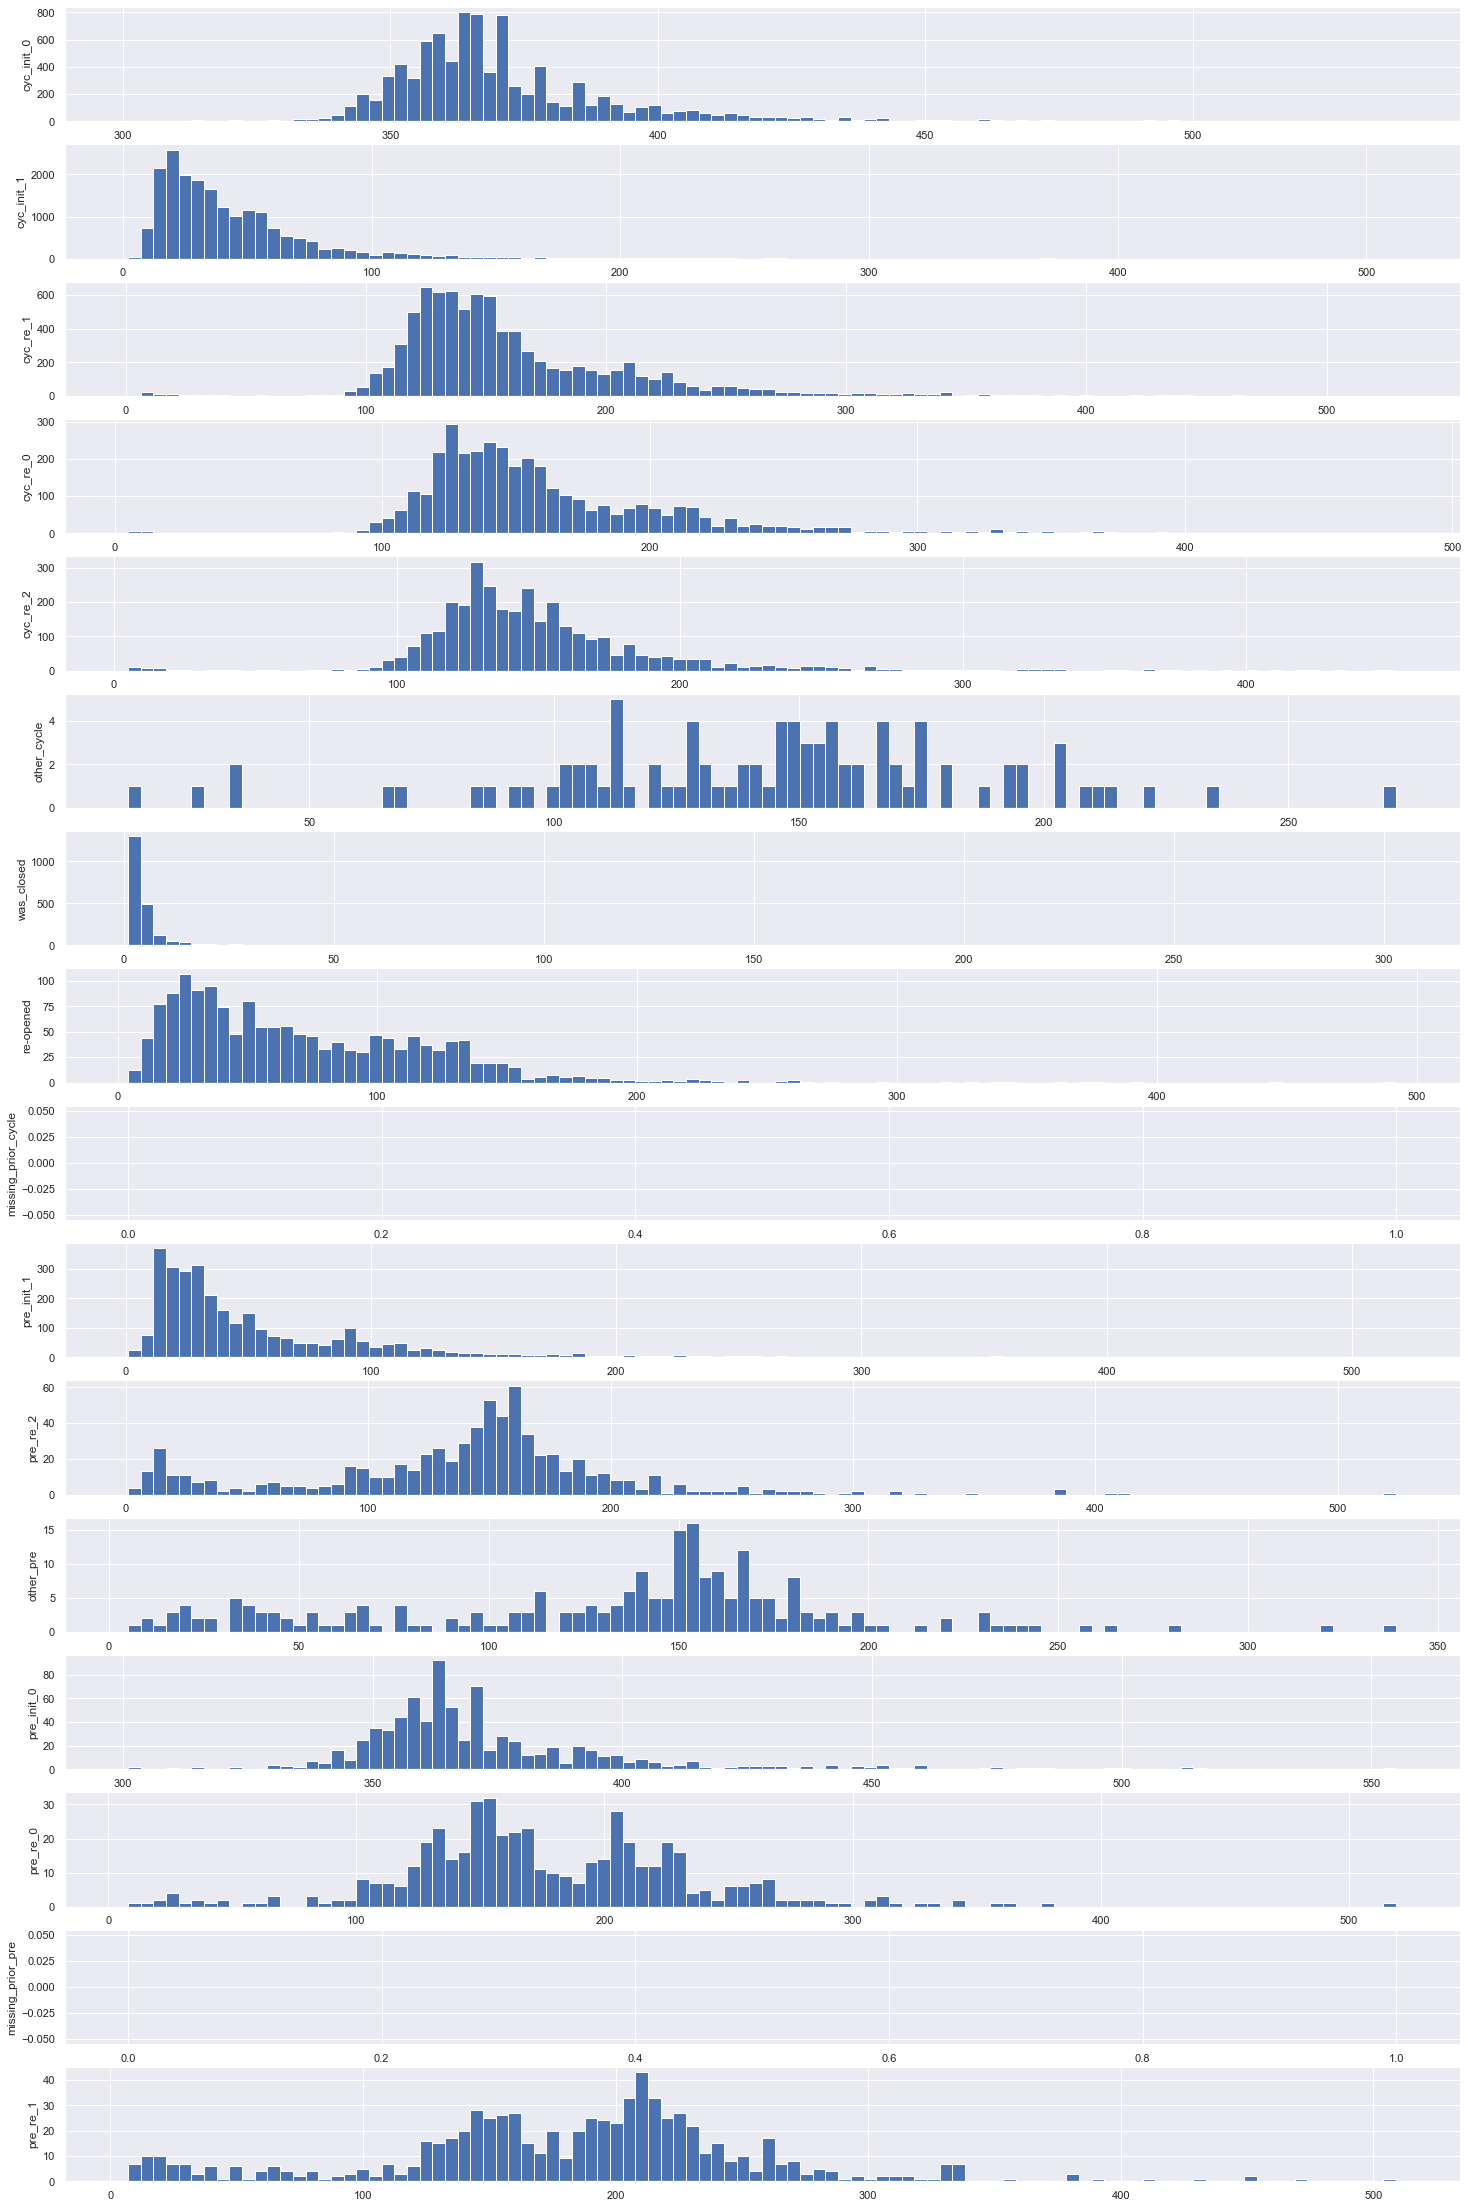

In [55]:
bin_types = df['inspection_bin'].unique()
plt.figure(figsize=(25,40))

count = 1
for i in bin_types:
    plt.subplot(len(bin_types),1,count)
    x = df[(df['inspection_bin']==i) & (df['event']==1)& (df['inspection_date']>='2018-01-01')]['time_til']
    plt.hist(x, bins=100)
    plt.ylabel(i)
    count += 1
    
plt.show()

In [299]:
cols = ['event','time_til','inspection_bin','monday',
       'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']

In [306]:
X = df[(df['inspection_date']>='2018-01-01') &
       (df['event']>=1) &
       (df['time_til']<500)][cols]

from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
# cph.fit(X, 'time_til', event_col='event', strata = ['inspection_bin'], show_progress=True, step_size=.1)
# cph.print_summary()

scores = k_fold_cross_validation(cph, X, 'T', event_col='E', k=3, fitter_kwargs={strata:'inspection_bin'})
print(scores)
print(np.mean(scores))
print(np.std(scores))

NameError: name 'strata' is not defined

In [124]:
test = np.array([[0,0,99,1,0,0,0,0,0]])
test_frame = pd.DataFrame(test,columns=X.columns)
test_frame.loc[0,'inspection_bin'] = 're-opened'

In [125]:
test_frame

,event,time_til,inspection_bin,monday,tuesday,wednesday,thursday,friday,saturday
0,0,0,re-opened,1,0,0,0,0,0


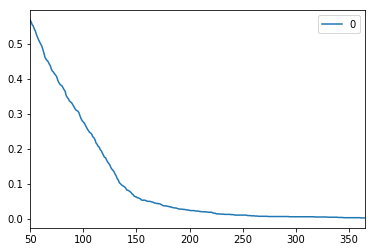

In [118]:
cph.predict_survival_function(test_frame)[50:365].plot()

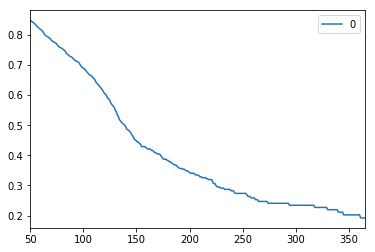

In [120]:
cph.predict_survival_function(test_frame)[50:365].plot()

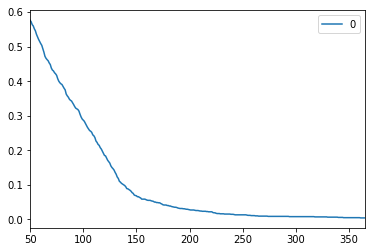

In [123]:
cph.predict_survival_function(test_frame)[50:365].plot()

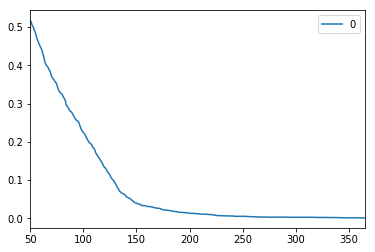

In [126]:
cph.predict_survival_function(test_frame)[50:365].plot()

In [38]:
censored_subjects = df.loc[(df['event']==0)& (df['time_til']<500)]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df.loc[c.name, 'time_til']]).clip_upper(1))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
unconditioned_sf.iloc[:1,13532]
# unconditioned_sf

1.0    1.0
Name: 118825, dtype: float64

In [43]:
from lifelines.utils import median_survival_times, qth_survival_times

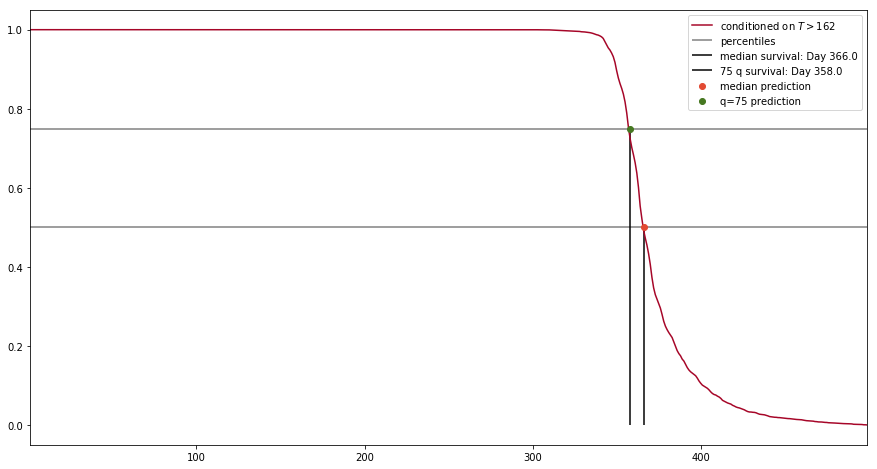

In [44]:
plt.figure(figsize=(15,8))
subject = 118825
# unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>{}$".format(df.loc[subject,'time_til']))

# predictions_50 = median_survival_times(conditioned_sf)
# predictions_75 = qth_survival_times(0.75, conditioned_sf)

plt.hlines([0.5, 0.75], 0, 550, alpha=0.5, label="percentiles")
plt.vlines(median_survival_times(conditioned_sf[subject]), 0, .5, label="median survival: Day {}".format(median_survival_times(conditioned_sf[subject])))
plt.vlines(qth_survival_times(0.75, conditioned_sf[subject]), 0, .75, label="75 q survival: Day {}".format(qth_survival_times(0.75, conditioned_sf[subject])))


plt.scatter(median_survival_times(conditioned_sf[subject]), 0.5,  color="#E24A33", label="median prediction", zorder=20)
plt.scatter(qth_survival_times(0.75, conditioned_sf[subject]), 0.75,  color="#467821", label="q=75 prediction", zorder=20)
            
            
plt.legend();



=========================================================

Daily inspection parser

In [ ]:
# data.sort_values(['CAMIS','INSPECTION DATE'])

In [ ]:
# import os

# outname = 'first_report.csv'

# outdir = './dir'
# if not os.path.exists(outdir):
#     os.mkdir(outdir)

# fullname = os.path.join(outdir, outname)    

# data.to_csv(fullname)

In [ ]:
first = pd.read_csv('./assets/first_report.csv')




In [ ]:
first.dropna(subset=['DBA'], inplace=True)

In [ ]:
first[first['DBA'].str.contains('telle')]

In [ ]:
first_insp = df[df['INSPECTION DATE']>='2019-02-21']

In [ ]:
to_compare = pd.read_csv('./assets/archive/DOHMH_New_York_City_Restaurant_Inspection_Results (8).csv')
to_compare['RECORD DATE']=pd.to_datetime(to_compare['RECORD DATE'],errors='coerce', format='%m/%d/%Y')
to_compare['INSPECTION DATE']=pd.to_datetime(to_compare['INSPECTION DATE'],errors='coerce', format='%m/%d/%Y')

In [ ]:
first_compare = to_compare[to_compare['INSPECTION DATE']>='2019-02-21']

first_compare = first_compare[['CAMIS','DBA','RECORD DATE','INSPECTION DATE',\
                               'VIOLATION CODE', 'SCORE','INSPECTION TYPE']]

In [ ]:
pd.concat([first_compare,first_insp]).sort_values(['CAMIS','INSPECTION DATE',\
                                                   'RECORD DATE']).reset_index(drop=True).loc[3000:4000,:]

In [ ]:
y = first_compare['VIOLATION CODE'].value_counts()
x = first_insp['VIOLATION CODE'].value_counts()
violation_diff = pd.concat([x,y], axis=1, sort=True)
cols = ['first','last']
violation_diff.columns = cols

In [ ]:
violation_diff['diff'] = violation_diff['first'] - violation_diff['last']

In [ ]:
violation_diff.sort_values('diff',ascending=False, inplace=True)
violation_diff['percent'] = violation_diff['diff']/violation_diff['first']

In [ ]:
violation_diff.sort_values(['first'],ascending=False, inplace=True)

In [ ]:
1-12330/12959

In [ ]:
violation_diff[violation_diff['first']>500]

In [ ]:
# plt.figure(figsize=(25,15))
# sns.barplot(data['VIOLATION CODE'].value_counts()[:20].index, data['VIOLATION CODE'].value_counts()[:20].values)

In [ ]:
to_compare[(to_compare['CAMIS']==30075445) &
         (  to_compare['INSPECTION DATE']=='2019-05-16')][['SCORE', 'VIOLATION CODE']]

Geo fencing angle

In [ ]:
cut_size = 200
prec = 6

df['lat_cell'] = pd.cut(df['latitude'], cut_size, labels=range(0,cut_size), precision=prec)
df['lng_cell'] = pd.cut(df['longitude'], cut_size, labels=range(0,cut_size), precision=prec)

In [ ]:
df['cell'] = list(zip(df['lat_cell'],df['lng_cell']))

In [ ]:
inspection_date_matrix = pd.pivot_table(df.loc[:,['inspection_date','cell']], fill_value=0, index = ['inspection_date'], columns = ['cell'], aggfunc=len)


In [ ]:
# df[df['cell'].isin(c)].drop_duplicates('camis')

In [ ]:
df = df.dropna(axis=0, subset=['latitude','longitude'])
df = df[df['inspection_date'] >= '2018-01-01']
df.reset_index(drop=True, inplace=True)

In [ ]:
cell_lenghts = df.drop_duplicates(['camis']).groupby('cell').size()

In [ ]:
start = datetime.datetime.now()

heat_list = []
num_rest = []

for i in range(len(df)):
    try:
        cell = df.loc[i,'cell']
        size = 1
        x = cell[0]
        y = cell[1]

        list1=range(x-size,x+size+1)
        list2=range(y-size,y+size+1)

        c = list(itertools.product(list1,list2))

        date_rng = pd.date_range(df.loc[i,'inspection_date'], periods=10) - pd.Timedelta(days=10)
        test_date = [str(x)[:10] for x in date_rng]

        heat_list.append(inspection_date_matrix.loc[test_date,c].sum().sum())
        num_rest.append(cell_lenghts.loc[c].sum())
        
    except TypeError:
        print(i)
        break
        
    except KeyError:
        print(i)
        break
        
print(datetime.datetime.now() - start)

In [ ]:
df['rest_per_cell'] = pd.Series(num_rest)

In [ ]:
df['heat_index'] = pd.Series(heat_list)

In [ ]:
df['adj_heat_index'] = df['heat_index'] / df['rest_per_cell']

In [ ]:
df['sqrt_heat'] = df['heat_index'].apply(lambda x: x**.5)

In [ ]:
# df.to_csv('./assets/df_with_heat.csv')

In [ ]:
df = pd.read_csv('./assets/df_with_heat.csv')

In [ ]:
sns.distplot(df['adj_heat_index'])

In [ ]:
i_bins = df['inspection_bin'].unique()

In [ ]:
from lifelines import KaplanMeierFitter
plt.figure(figsize=(25,20))
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

for i in i_bins:
    kmf.fit(df[df['inspection_bin']==i]['time_til'], event_observed=df[df['inspection_bin']==i]['event'], label=i)
    kmf.plot(ax=ax)

In [ ]:
bandwidth = 20.

# naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
# ax = naf.plot_hazard(bandwidth=bandwidth)

# naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
# naf.plot_hazard(ax=ax, bandwidth=bandwidth)

# plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
# plt.ylim(0, 0.4)
# plt.xlim(0, 25);


from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
plt.figure(figsize=(25,20))


for i in i_bins:
    naf.fit(df[df['inspection_bin']==i]['time_til'], event_observed=df[df['inspection_bin']==i]['event'], label=i)
    ax = naf.plot()

In [ ]:
df.columns

In [ ]:
sns.distplot(df['adj_heat_index'])
df['adj_heat_index'].max()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
sns.distplot(df[['adj_heat_index']])

In [ ]:
# sns.distplot(df['adj_heat_index'].apply(lambda x: np.log(x+1)))
sns.distplot(df['adj_heat_index'].apply(lambda x: (x+1)**2))

In [ ]:
df[df['event']==1].columns

In [ ]:
cols = ['cyc_init_1', 'cyc_re_0',
       'cyc_re_1', 'cyc_re_2', 'pre_init_0', 'pre_init_1', 'pre_re_0',
       'pre_re_1', 'pre_re_2', 're-opened', 'was_closed']
X = df[df['event']==1][cols]
y = df[df['event']==1]['time_til']

In [366]:
# df.to_csv('./assets/df_with_fines.csv')

In [381]:
df.groupby(['year'])[['new_low','new_high']].agg(np.sum)

,new_low,new_high
year,,
2013,0.0,0.0
2014,2750.0,3500.0
2015,366450.0,550350.0
2016,7827050.0,11983500.0
2017,12759600.0,19389750.0
2018,19594000.0,29807750.0
2019,17330350.0,26567550.0


In [5]:
import requests
import lxml.html as lh
import pandas as pd

In [6]:
url='https://en.wikipedia.org/wiki/List_of_restaurant_chains_in_the_United_States'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [31]:
#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

In [8]:

#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print('%d:"%s"'%(i,name))
    col.append((name,[]))

1:"Name
"
2:"Original location
"
3:"Year started
"
4:"Headquarters
"
5:"Number of worldwide locations
"
6:"Number of states with locations
"
7:"Notes
"


In [9]:
col

[('Name\n', []),
 ('Original location\n', []),
 ('Year started\n', []),
 ('Headquarters\n', []),
 ('Number of worldwide locations\n', []),
 ('Number of states with locations\n', []),
 ('Notes\n', [])]

In [10]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
#     if len(T)!=10:
#         break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [35]:
[len(C) for (title,C) in col]

[402, 401, 390, 390, 390, 390, 383]

In [14]:
restaurants = list(col[0])[1]

restaurants = pd.Series(restaurants).apply(lambda x: x[:-1])

In [24]:
restaurants = restaurants[:390]

In [25]:
restaurants = restaurants.str.lower()

In [43]:
df_rest = df['dba'].str.lower()

In [32]:
restaurants[restaurants.str.contains('dom')]

188    domino's pizza
dtype: object

In [41]:
domino_index = df_rest[df_rest.str.contains('domino')].index

df.loc[domino_index,'dba'] = "domino's pizza"

In [47]:
chain_df = pd.DataFrame([df_rest,df_rest.isin(restaurants)]).T

In [51]:
chain_df.columns = ['dba','chain']



,dba,chain


In [73]:
chain_df[chain_df['chain']==False].drop_duplicates()

,dba,chain
0,morris park bake shop,False
1,morris park bake shop,False
2,morris park bake shop,False
3,morris park bake shop,False
12,dj reynolds pub and restaurant,False
...,...,...
129008,casa coriz mexican restaurant,False
129009,same canteen,False
129010,tea la ra,False
129011,tea la ra,False


In [39]:
# df_rest.drop_duplicates(inplace=True)

In [40]:
is_chain = pd.DataFrame([df_rest,df_rest.isin(rests)]).T
# df_rest
# df[df['cell'].isin(c)].drop_duplicates('camis')

In [41]:
is_chain.columns = ['dba','chain']

In [44]:
df['chain'] = is_chain['chain']

The Plots

In [48]:
len(df[df['is_chain']==1].drop_duplicates('camis')) / len(df.drop_duplicates('camis'))

0.1713570981863665

In [54]:
df[df['camis']==41077320]['codes']

19455           ['10B', '06C', '22F']
19456           ['10F', '10B', '06C']
19457    ['02B', '10B', '02G', '10F']
19458    ['06C', '10F', '10B', '10H']
Name: codes, dtype: object

Initial Success

In [35]:
df[df['inspection_type'].str.contains('Cycle')].groupby(['camis','year'])[['new_low','new_high']].sum()

new_low  new_high
camis    year                   
30075445 2017      0.0       0.0
         2018      0.0       0.0
         2019   1200.0    1350.0
30112340 2016   2200.0    2900.0
         2017    450.0     800.0
...                ...       ...
50093846 2019      0.0       0.0
50094248 2019      0.0       0.0
50094372 2019      0.0       0.0
50094524 2019      0.0       0.0
50094857 2019      0.0       0.0

[64393 rows x 2 columns]

In [59]:
re_inspected = df[(df['inspection_type'].str.contains('Cycle')) & 
                  (df['new_low']>0) &
                  (df['year']>2017) &
                  (df['year']<2019)]

re_inspected_total = re_inspected.groupby(['camis'])[['new_low','new_high','avg_est']].sum()

In [55]:
all_cycle = df[(df['year']==2018) &
  (df['inspection_type'].str.contains('Cycle'))]

all_cycle_total = all_cycle.groupby(['camis'])[['new_low','new_high']].sum()

In [229]:
df['inspection_type'].unique()

array(['Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Re-inspection',
       'Cycle Inspection / Compliance Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Pre-permit (Non-operational) / Initial Inspection',
       'Pre-permit (Non-operational) / Re-inspection',
       'Pre-permit (Operational) / Compliance Inspection',
       'Cycle Inspection / Second Compliance Inspection',
       'Pre-permit (Operational) / Initial Inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Pre-permit (Operational) / Second Compliance Inspection',
       'Pre-permit (Operational) / Reopening Inspection',
       'Pre-permit (Non-operational) / Compliance Inspection',
       'Pre-permit (Non-operational) / Second Compliance Inspection'],
      dtype=object)

In [57]:
all_cycle_total['new_low'].median(), all_cycle_total['new_low'].mean()

(0.0, 865.149439285533)

<Figure size 1080x720 with 0 Axes>

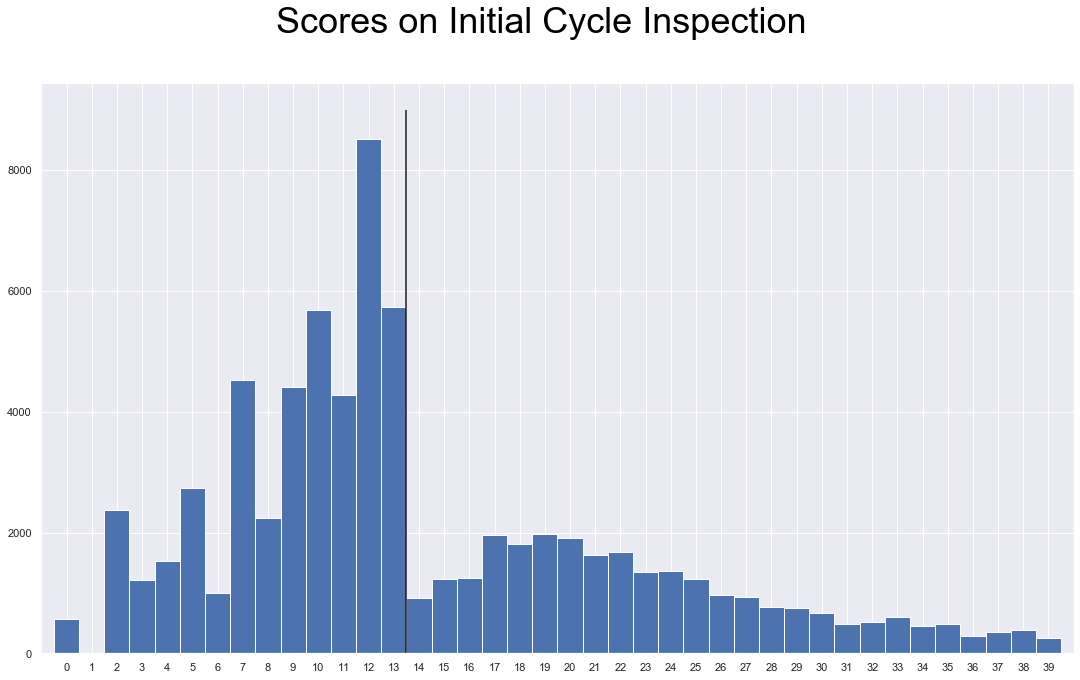

In [208]:
# plt.figure(figsize=(15,10))

init_score = df[(df['inspection_type']=='Cycle Inspection / Initial Inspection') & 
   (df['score']<40)]['score']

bins = np.arange(41) - 0.5

fig, ax = plt.subplots()

plt.hist(init_score, bins)
plt.xticks(range(40))
plt.xlim([-1, 40])
# title_obj = plt.title('Scores on Initial Cycle Inspection', fontdict={'fontsize':30}, pad=15)
fig.suptitle('Scores on Initial Cycle Inspection', fontsize=36, color='black')

plt.setp(title_obj, color='w')
plt.vlines(13.5,0,9000)

fig.set_size_inches(18.5, 10.5)

plt.savefig('initial_scores')
plt.show()

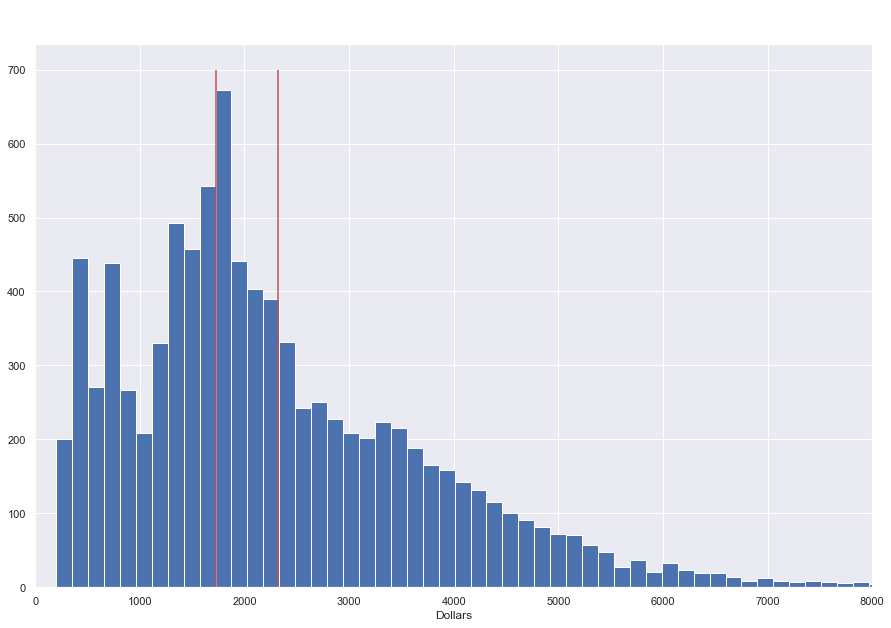

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

x = re_inspected_total['avg_est']

bins = 75
plt.hist(x, bins)
# plt.xticks(range(40))
plt.xlabel('Dollars')
plt.xlim([0, 8000])
plt.vlines([x.quantile([.4,.6])], 0, 700, colors='r')
title_obj = plt.title('2018 Estimated Fines', fontdict={'fontsize':30}, pad=15)
plt.setp(title_obj, color='w')

plt.savefig('fine_est')
plt.show()

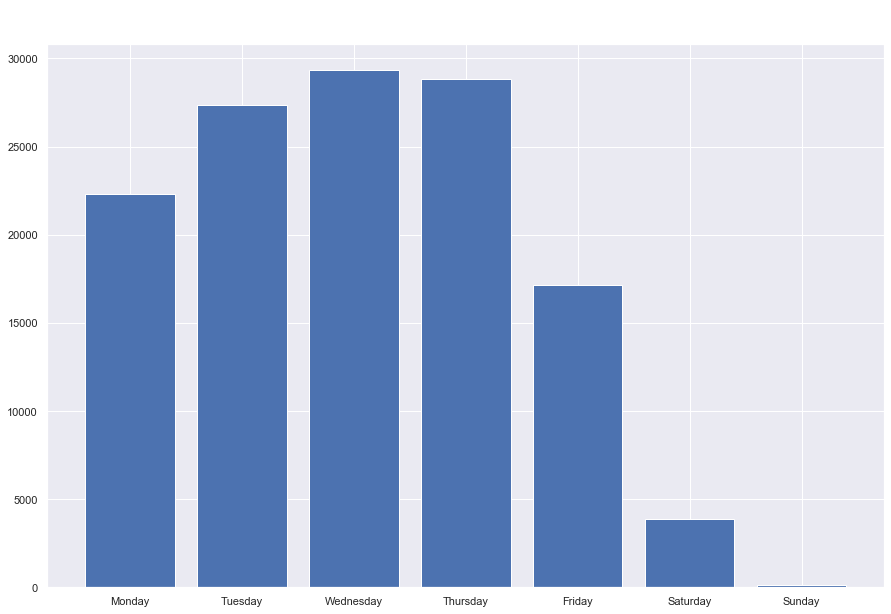

In [169]:
x = pd.to_datetime(df['inspection_date']).dt.day_name()

x = pd.Categorical(x, categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

x = x.value_counts()
x = x.sort_index()

plt.figure(figsize=(15,10))

title_obj = plt.title('Health Inspections by Day of Week', fontdict={'fontsize':30}, pad=15)
plt.setp(title_obj, color='w')

plt.bar(x.index, x);

In [190]:
df['day_of_week'] = pd.to_datetime(df['inspection_date']).dt.day_name()
df['day_of_week'] = df['day_of_week'].apply(lambda x: 'Weekend' if x=='Saturday' or x=='Sunday' else x)

In [208]:
# pd.get_dummies(df['day_of_week'], drop_first=True)

In [209]:
# df = df.join(pd.get_dummies(df['day_of_week'], drop_first=False))

In [199]:
cols = ['event','time_til','inspection_bin', 'Monday', 'Thursday', 'Tuesday',
        'Wednesday', 'Weekend']

In [197]:
X = df[(df['inspection_date']>='2018-01-01') &
       (df['event']==1) &
       (df['time_til']<500)][cols]

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(X, 'time_til', event_col='event', strata = ['inspection_bin'], show_progress=True, step_size=.1)
cph.print_summary()

Iteration 1: norm_delta = 0.00704, step_size = 0.1000, ll = -429723.61718, newton_decrement = 169.30990, seconds_since_start = 1.6
Iteration 2: norm_delta = 0.00640, step_size = 0.1000, ll = -429691.44162, newton_decrement = 139.00206, seconds_since_start = 2.8
Iteration 3: norm_delta = 0.00583, step_size = 0.1000, ll = -429665.02589, newton_decrement = 114.07566, seconds_since_start = 4.0
Iteration 4: norm_delta = 0.00636, step_size = 0.1200, ll = -429643.34728, newton_decrement = 93.57334, seconds_since_start = 5.1
Iteration 5: norm_delta = 0.00556, step_size = 0.1176, ll = -429622.23140, newton_decrement = 73.54436, seconds_since_start = 6.2
Iteration 6: norm_delta = 0.00487, step_size = 0.1152, ll = -429605.94688, newton_decrement = 58.04644, seconds_since_start = 7.3
Iteration 7: norm_delta = 0.00523, step_size = 0.1383, ll = -429593.33561, newton_decrement = 46.00308, seconds_since_start = 8.5
Iteration 8: norm_delta = 0.00447, step_size = 0.1355, ll = -429581.48773, newton_decre

In [27]:
path = "C:/Users/a/Documents/Projects/doh/"
extension = 'csv'
os.chdir(path)

all_violations = pd.read_csv('./assets/archive/DOHMH_New_York_City_Restaurant_Inspection_Results_9_11_19.csv')            

    
    

In [28]:
all_violations.dropna(axis=0, subset=['INSPECTION TYPE','VIOLATION CODE'], inplace=True)
violation_counts = all_violations[all_violations['INSPECTION TYPE'].str.contains('Cycle')]['VIOLATION CODE'].value_counts()


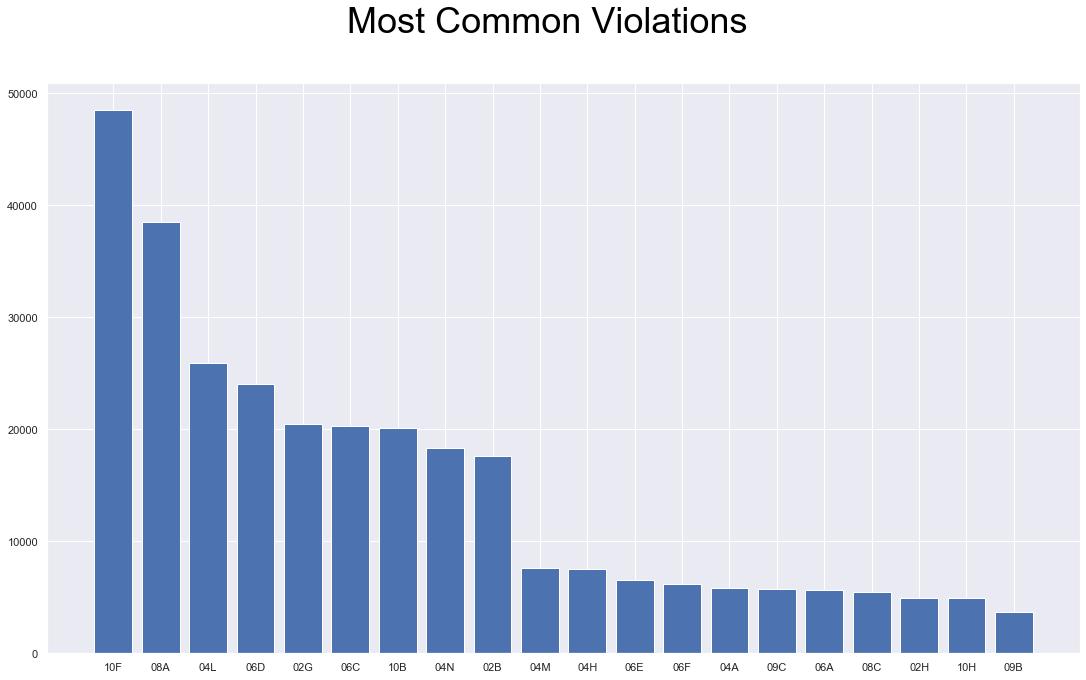

In [34]:
x = violation_counts[:20]

fig, ax = plt.subplots()

# plt.figure(figsize=(15,10))

# title_obj = plt.title('Most Commonly Cited Violations', fontdict={'fontsize':30}, pad=15)

fig.suptitle('Most Common Violations', fontsize=36, color='black')

# plt.setp(title_obj, color='w')

plt.bar(x.index, x)

fig.set_size_inches(18.5, 10.5)
plt.savefig('common_violations')
plt.show();

In [255]:
for i in x:
    print(i/violation_counts.sum())

0.1495486891962663
0.11862542743600012
0.07989587505006007
0.07422137334031607
0.06295246603616647
0.06263516219463355
0.06203136070977481
0.05642771325590709
0.05418502202643172
0.023378823819352454
0.02320630910939281
0.020165737346354087
0.01897353747574012
0.017960013554727212
0.017676596531222083
0.017371615168971996
0.01695573149317643
0.015292196789994147
0.015147407658420875
0.01135208403930871


In [279]:
count = 1
for i in x.index[:9]:
    print('{}: {}'.format(count,all_violations[all_violations['VIOLATION CODE']==i]['VIOLATION DESCRIPTION'].iloc[0]))
    print(i)
    print('\n')
    count+=1

1: Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.
10F


2: Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.
08A


3: Evidence of mice or live mice present in facility's food and/or non-food areas.
04L


4: Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.
06D


5: Cold food item held above 41º F (smoked fish and reduced oxygen packaged foods above 38 ºF) except during necessary preparation.
02G


6: Food not protected from potential source of contamination during storage, preparation, transportation, display or service.
06C


7: Plumbing not properly installed or maintained; anti-siphonage or 

In [276]:
by_category = all_violations['VIOLATION CODE'].str.replace('[A-Z]', '').value_counts()

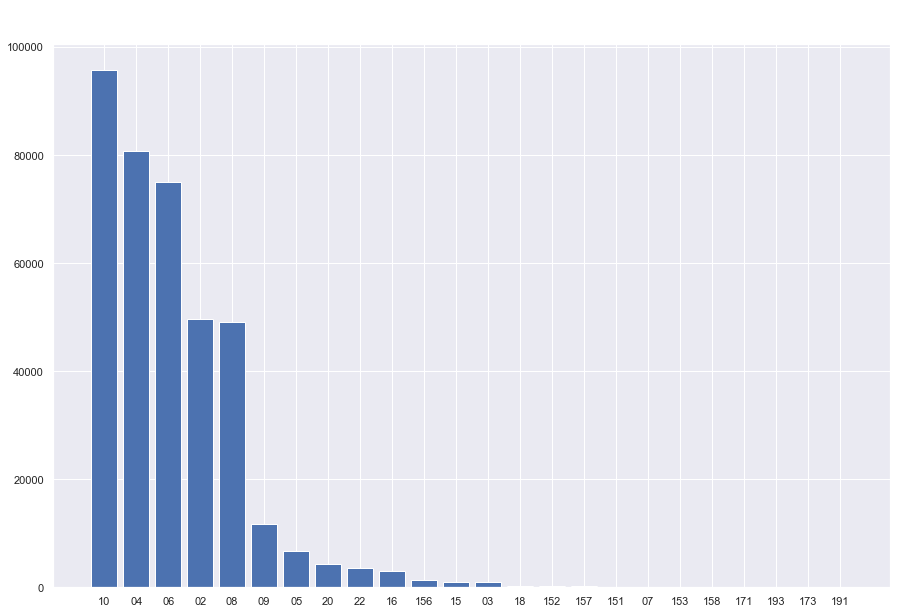

In [277]:
plt.figure(figsize=(15,10))

title_obj = plt.title('Most Commonly Cited Violations', fontdict={'fontsize':30}, pad=15)
plt.setp(title_obj, color='w')

plt.bar(by_category.index, by_category);

In [278]:
for i in by_category:
    print(i/by_category.sum())

0.2494201196987486
0.21012362969924323
0.19546977463417428
0.1294662497949918
0.1280344465820254
0.030403690407699458
0.017395107398257365
0.011399756853781652
0.009447297927009275
0.00778380292139921
0.003477980168223861
0.002782904790292895
0.002605881847598866
0.0007471409493115629
0.00042954096388992297
0.00039049178535447543
0.00036185572109514725
0.00010933769989925312
8.070163563992492e-05
5.466884994962656e-05
5.206557138059672e-06
5.206557138059672e-06
2.603278569029836e-06
2.603278569029836e-06


In [23]:
# import matplotlib.pyplot as plt
# import numpy as np


# chain = df[(df['is_chain']==1) & (df['score']<50)]['score']
# not_chain = df[(df['is_chain']==0) & (df['score']<50)]['score']

# l = 50
# xweights = 100 * np.ones_like(chain) / chain.size
# yweights = 100 * np.ones_like(not_chain) / not_chain.size

# fig, ax = plt.subplots()
# ax.hist(chain, bins = l, weights=xweights, color='blue', alpha=1, density=True)
# ax.hist(not_chain, bins = l, weights=yweights, color='salmon', alpha=.6, density=True)

# ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
# ax.margins(0.05)
# ax.set_ylim(bottom=0)
# plt.vlines(14,0,.16)

# fig.set_size_inches(18.5, 10.5)
# plt.show();

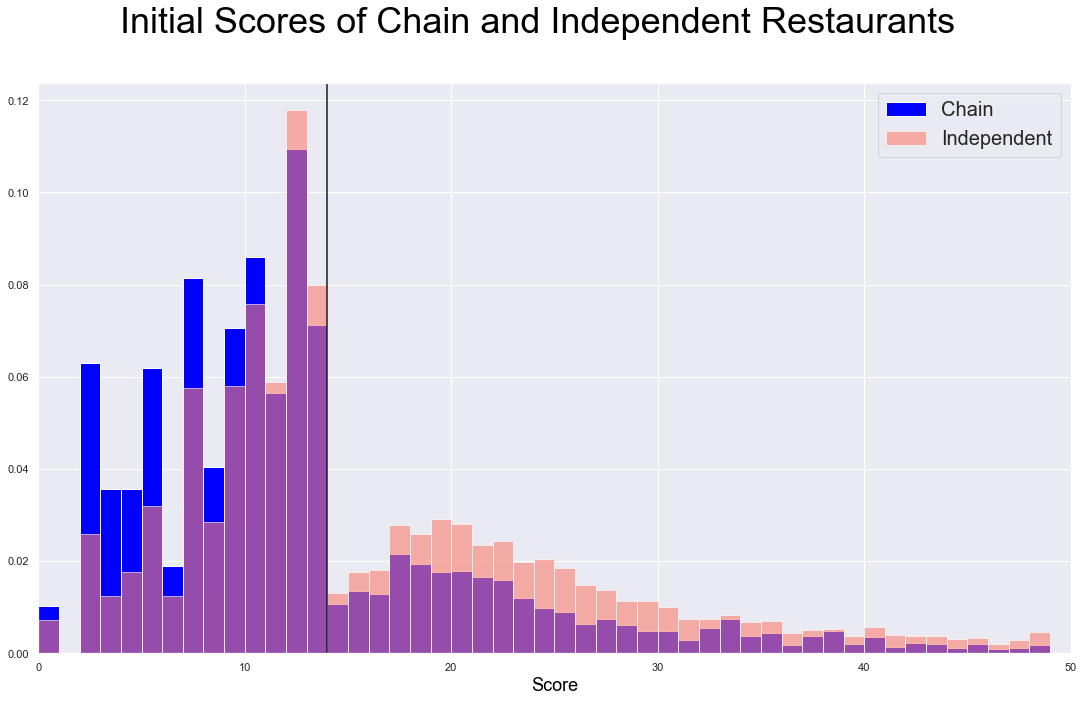

In [22]:
import matplotlib.pyplot as plt
import numpy as np


chain = df[(df['is_chain']==1) & (df['inspection_type'].str.contains('Cycle Inspection / Initial Inspection')) &
          (df['score']<50)]['score']
not_chain = df[(df['is_chain']==0) & (df['inspection_type'].str.contains('Cycle Inspection / Initial Inspection')) &
              (df['score']<50)]['score']

l = 50
xweights = 100 * np.ones_like(chain) / chain.size
yweights = 100 * np.ones_like(not_chain) / not_chain.size

fig, ax = plt.subplots()
ax.hist(chain, bins = l, weights=xweights, color='blue', alpha=1, density=True, label='Chain')
ax.hist(not_chain, bins = l, weights=yweights, color='salmon', alpha=.6, density=True, label='Independent')

fig.suptitle('Initial Scores of Chain and Independent Restaurants', fontsize=36, color='black')
ax.set_xlabel('Score', fontsize=18, color='black')

ax.margins(0.05)
ax.set_ylim(bottom=0)
ax.set_xlim(0,50)
plt.vlines(14,0,.16)

ax.legend(prop={'size':20})

fig.set_size_inches(18.5, 10.5)
plt.savefig('chain_v_ind_score')
plt.show();

In [231]:
l = df[(df['is_chain']==1) & (df['inspection_type']=='Cycle Inspection / Initial Inspection')]
p = df[(df['is_chain']==1) & (df['inspection_type']=='Cycle Inspection / Initial Inspection')
      & (df['score']<14)]
len(p)/len(l)

0.7336725394896719

In [230]:
l = df[(df['is_chain']==0) & (df['inspection_type']=='Cycle Inspection / Initial Inspection')]
p = df[(df['is_chain']==0) & (df['inspection_type']=='Cycle Inspection / Initial Inspection')
      & (df['score']<14)]
len(p)/len(l)

0.5703019780291106

In [232]:
l = df[(df['inspection_type']=='Cycle Inspection / Initial Inspection')]
p = df[(df['inspection_type']=='Cycle Inspection / Initial Inspection')
      & (df['score']<14)]
len(p)/len(l)

0.5990641085634066

In [241]:
re_inspected_total_chain = re_inspected.groupby(['is_chain','camis'])[['new_low','new_high','avg_est']].sum()

In [256]:
re_inspected_total_chain.loc[1]['avg_est'].median()

1650.0

In [257]:
re_inspected_total_chain.loc[0]['avg_est'].median()

2025.0

In [39]:
df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'], format="%m/%d/%Y")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df = df.sort_values(['CAMIS','INSPECTION DATE']).iloc[:,:16]

In [43]:
df.sort_values(["key","INSPECTION DATE"],ascending=[True,False])

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,KEY,key
47108,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2017-05-18,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,7.0,A,05/18/2017,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2017-05-18
85357,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2018-05-11,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,5.0,A,05/11/2018,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2018-05-11
106618,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2019-05-16,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,14.0,NaN,NaN,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2019-05-16
215674,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2019-06-11,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,6.0,A,06/11/2019,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2019-06-11
171095,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-04-12,No violations were recorded at the time of thi...,NaN,NaN,NaN,0.0,NaN,NaN,WENDY'S 469 FLATBUSH AVENUE 11225.0,30112340 2016-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248430,50099478,BAREBURGER,Manhattan,795,COLUMBUS AVE,10025.0,9175235650,Other,1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BAREBURGER 795 COLUMBUS AVE 10025.0,50099478 1900-01-01
92488,50099479,NaN,Manhattan,42,W 42ND ST,10036.0,9179910564,Other,1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan 42 W 42ND ST 10036.0,50099479 1900-01-01
330250,50099481,CAFE GREENPOINT,Brooklyn,650,MANHATTAN AVE,11222.0,6465259891,Other,1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAFE GREENPOINT 650 MANHATTAN AVE 11222.0,50099481 1900-01-01
355907,50099482,NaN,Queens,6692,FOREST AVE,11385.0,3476892670,Other,1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan 6692 FOREST AVE 11385.0,50099482 1900-01-01


In [27]:
df['key'] = df[['CAMIS','INSPECTION DATE']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [32]:
df = df.drop_duplicates('key')

In [44]:
df['last'] = df['INSPECTION DATE'].shift()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
df.head(10)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,KEY,key,last
47108,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2017-05-18,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,7.0,A,05/18/2017,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2017-05-18,NaT
85357,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2018-05-11,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,5.0,A,05/11/2018,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2018-05-11,2017-05-18
106618,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2019-05-16,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,14.0,NaN,NaN,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2019-05-16,2018-05-11
215674,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2019-06-11,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,6.0,A,06/11/2019,MORRIS PARK BAKE SHOP 1007 MORRIS PARK AVE 104...,30075445 2019-06-11,2019-05-16
171095,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-04-12,No violations were recorded at the time of thi...,NaN,NaN,NaN,0.0,NaN,NaN,WENDY'S 469 FLATBUSH AVENUE 11225.0,30112340 2016-04-12,2019-06-11
141398,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-04-30,Violations were cited in the following area(s).,15I,"""""No Smoking” and/or 'Smoking Permitted” sign ...",N,NaN,NaN,NaN,WENDY'S 469 FLATBUSH AVENUE 11225.0,30112340 2016-04-30,2016-04-12
109909,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-10-03,Violations were cited in the following area(s).,10A,Toilet facility not maintained and provided wi...,N,48.0,NaN,NaN,WENDY'S 469 FLATBUSH AVENUE 11225.0,30112340 2016-10-03,2016-04-30
38096,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-10-27,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,11.0,A,10/27/2016,WENDY'S 469 FLATBUSH AVENUE 11225.0,30112340 2016-10-27,2016-10-03
62718,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2017-06-26,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,7.0,NaN,NaN,WENDY'S 469 FLATBUSH AVENUE 11225.0,30112340 2017-06-26,2016-10-27
272947,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2017-10-06,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,10.0,A,10/06/2017,WENDY'S 469 FLATBUSH AVENUE 11225.0,30112340 2017-10-06,2017-06-26


In [ ]:
df.loc[df.drop_duplicates("KEY").index,"NEXT_GRADE_DATE"] = pd.NaT